In [8]:
cd ..

/home/3005019/Deep Learning/LieDetection/home/3005019/Deep Learning/LieDetection/src


In [9]:
run_config = "../config/run.yaml"

2019-11-07 15:06:29,620 - __main__ - INFO - Run configuration file: ../config/run.yaml
2019-11-07 15:06:29,636 - __main__ - INFO - Loading images...


<class 'tuple'>
(224, 224)


100%|██████████| 100/100 [00:00<00:00, 132.51it/s]
2019-11-07 15:06:30,652 - __main__ - INFO - Images loaded successfully.
2019-11-07 15:06:30,655 - __main__ - INFO - Total number of frames loaded: 100
2019-11-07 15:06:30,658 - __main__ - INFO - Processing data...
2019-11-07 15:06:30,711 - __main__ - INFO - Performing data augmentation...
2019-11-07 15:06:30,713 - __main__ - INFO - Building the model...



 Time taken: 0 hours 0 minutes and 0.77 seconds.



2019-11-07 15:06:30,952 - tensorflow - WARNING - From /home/3005019/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

/home/3005019/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


2019-11-07 15:06:40,402 - tensorflow - WARNING - From /home/3005019/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

2019-11-07 15:06:40,478 - __main__ - INFO - Compiling model...
2019-11-07 15:06:40,578 - __main__ - INFO - Training head of the model...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-11-07 15:06:40,756 - tensorflow - WARNING - From /home/3005019/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-11-07 15:06:41,596 - tensorflow - WARNING - From /home/3005019/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/5
2/2 [==============================] - 12s 6s/step - loss: 6.2291 - accuracy: 0.6250 - val_loss: 6.9000 - val_accuracy: 0.5500
Epoch 2/5
2/2 [==============================] - 4s 2s/step - loss: 8.1458 - accuracy: 0.4688 - val_loss: 6.9000 - val_accuracy: 0.5500
Epoch 3/5
2/2 [==============================] - 4s 2s/step - loss: 5.7500 - accuracy: 0.6250 - val_loss: 6.9000 - val_accuracy: 0.5500
Epoch 4/5
2/2 [==============================] - 4s 2s/step - loss: 6.7083 - accuracy: 0.5625 - val_loss: 6.9000 - val_accuracy: 0.5500
Epoch 5/5
2/2 [==============================] - 4s 2s/step - loss: 6.7083 - accuracy: 0.5625 - val_loss: 6.9000 - val_accuracy: 0.5500


2019-11-07 15:07:09,609 - __main__ - INFO - Evaluating network...



 Time taken: 0 hours 0 minutes and 29.03 seconds.
              precision    recall  f1-score   support

         Lie       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



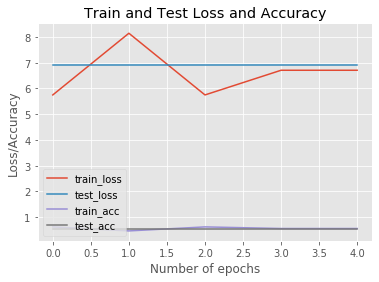

2019-11-07 15:07:14,487 - __main__ - INFO - Saving model...


<Figure size 432x288 with 0 Axes>

In [11]:
import click
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

import cv2
from imutils import paths
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Input
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import SGD

from utils import file_utils
from utils.model_utils import timer


def main(run_config):
    # Initialize
    logger = logging.getLogger(__name__)
    logger.info(f"Run configuration file: {run_config}")

    # Read configuration file
    run_cfg = file_utils.read_yaml(run_config)
    train = run_cfg["train"]
    plot_to_file = run_cfg["evaluation"]["plot_to_file"]
    plot_path = run_cfg["evaluation"]["plot"]
    model_name = run_cfg["modelling"]["model_name"]
    sample_mode = run_cfg["modelling"]["sample_mode"]
    data_augmentation = run_cfg["modelling"]["data_augmentation"]
    image_size = tuple(run_cfg["modelling"]["image_size"])

    # Grab the list of images and initialize the lists data and images
    logger.info("Loading images...")
    image_paths = list(paths.list_images(train))
    if sample_mode:
        n_frames = 100
        epochs = 5
        image_paths = random.choices(image_paths, k=n_frames)
    else:
        n_frames = 88017
        epochs = run_cfg["modelling"]["epochs"]
    data = []
    labels = []

    # Loop over the image paths
    start_time = timer(None)
    for i in tqdm(range(n_frames)):
        # Extract the class label from the filename
        image_path = image_paths[i]
        label = image_path.split(os.path.sep)[-2]

        # Load the image (reshape e rimappare i colori in base al pretrained model che andiamo a usare)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size[0:2])

        # Update data and label lists
        data.append(image)
        labels.append(label)
    logger.info("Images loaded successfully.")
    logger.info(f"Total number of frames loaded: {n_frames}")
    timer(start_time)

    # Convert data and labels to numpy arrays
    logger.info("Processing data...")
    os.environ['KMP_WARNINGS'] = 'off'
    data = np.array(data)
    labels = np.array(labels)

    # Perform one-hot encoding on the labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    # Train-test split (80%-20%)
    (X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

    # Initialize training data augmentation object
    if data_augmentation:
        logger.info("Performing data augmentation...")
        train_aug = ImageDataGenerator(
            rotation_range=30,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            fill_mode="nearest"
        )
    else:
        logger.info("Data augmentation not performed")
        train_aug = ImageDataGenerator()
    test_aug = ImageDataGenerator()

    # Center pixel values and intensities (to increase training speed and accuracy)
    # Se si vuole calcolare manualmente l'intensità media dei pixel: X_train.mean(axis=(0, 1, 2))
    mean = np.array([123.68, 116.779, 103.939], dtype="float32")
    train_aug.mean = mean
    test_aug.mean = mean

    # Load ResNet-50 network for fine tuning
    logger.info("Building the model...")
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=image_size))
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(512, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(1, activation="softmax")(head_model)
    model = Model(inputs=base_model.input, outputs=head_model)

    # Freeze the base model to prevent it from being updated during the training process
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    logger.info("Compiling model...")
    opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    # Train the head of the network (fine tuning)
    logger.info("Training head of the model...")
    start_time = timer(None)
    head = model.fit_generator(
        train_aug.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=len(X_train) // 32,
        validation_data=test_aug.flow(X_test, y_test),
        validation_steps=len(X_test) // 32,
        epochs=epochs
    )
    timer(start_time)

    # Evaluate the network
    logger.info("Evaluating network...")
    predictions = model.predict(X_test, batch_size=32)
    print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=["Lie"]))

    # Plot train loss and accuracy
    n = epochs
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, n), head.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n), head.history["val_loss"], label="test_loss")
    plt.plot(np.arange(0, n), head.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, n), head.history["val_accuracy"], label="test_acc")
    plt.title("Train and Test Loss and Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    if plot_to_file:
        plt.savefig(f"{plot_path}/loss_acc.png")

    # Save the model
    logger.info("Saving model...")
    try:
        model.save(f"../models/{model_name}/estimator.model")
    except OSError:
        os.mkdir(f"../models/{model_name}")
        model.save(f"../models/{model_name}/estimator.model")

    # Save the label binarizer
    f = open(f"../models/{model_name}/label_binarizer.pickle", "wb")
    f.write(pickle.dumps(lb))
    f.close()


log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
main(run_config)